<a href="https://colab.research.google.com/github/Terrencebosco/DS-Unit-2-Kaggle-Challenge/blob/master/module1-decision-trees/LS_DS_221_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [530]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [531]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [532]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

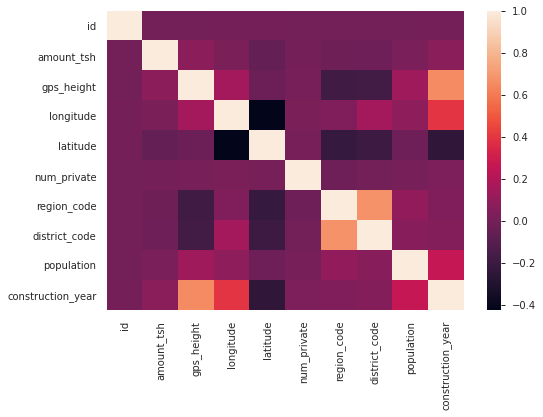

In [533]:
train_tab = train.corr()

sns.heatmap(train_tab)

In [534]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import category_encoders as ce
from sklearn.pipeline import make_pipeline 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [535]:
train, val = train_test_split(train)

train.shape, val.shape

((44550, 41), (14850, 41))

In [536]:
train['status_group'].value_counts(normalize=True)

functional                 0.542761
non functional             0.382963
functional needs repair    0.074276
Name: status_group, dtype: float64

In [537]:
px.scatter(train,x='longitude', y='latitude', color='status_group', opacity=.1)

In [541]:
def wrangle(x):

    x = x.copy()

    # replace small value with 0
    x['latitude'] = x['latitude'].replace(-2e-08, 0)

    # replacing missing values with nan
    cols_with_zero = ['latitude','longitude',
                      'construction_year','gps_height','population']

    # replace 0 with nan
    for col in cols_with_zero:
        x[col] = x[col].replace(0, np.nan)

    # replace nans in ward with mean of that ward
    for feature in cols_with_zero:
        mean_replace = x.groupby('ward')[feature].transform('mean')
        x[feature] = x[feature].fillna(mean_replace)
    
    # replace nan in region with mean of that region
    for feature in cols_with_zero:
        mean_replace = x.groupby('region_code')[feature].transform('mean')
        x[feature] = x[feature].fillna(mean_replace)

    # duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    x = x.drop(columns=duplicates)
    
    # drop unusable variance 
    unusable = ['amount_tsh','num_private', 'region', 
          'quantity', 'source_type', 
          'waterpoint_type_group',
         'extraction_type_group','scheme_name','recorded_by']
    x = x.drop(columns=unusable)

    # set recorded date to date time
    x['date_recorded'] = pd.to_datetime(x['date_recorded'],
                                        infer_datetime_format=True)
    
    chaning columns from int to str 
    x['region_code'] = x['region_code'].astype(str)
    x['district_code'] = x['district_code'].astype(str)

    # sperate date time into day,month,year, and drop original
    x['year_recorded'] = x['date_recorded'].dt.year
    x['month_recorded'] = x['date_recorded'].dt.month
    x['day_recorded'] = x['date_recorded'].dt.day

    # how many years from built to date recorded
    x['years'] = x['year_recorded'] - x['construction_year']

    number of missing yeats
    x['year_missing'] = x['years'].isnull()

    return x

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [542]:
# geo graph

# fig = px.scatter_mapbox(train, lat='latitude', lon='longitude', color='status_group', opacity=0.1)
# fig.update_layout(mapbox_style='stamen-terrain')
# fig.show()

In [543]:
# selecting features

# y variable 
target = 'status_group'

# drop target
train_features = train.drop(columns=[target])

# variable numeric features
numeric_features = train_features.select_dtypes(include='number').columns.to_list()

# variable high cardinality features 
high_cardinality_features = train_features.select_dtypes(exclude='number').nunique()

# catigorical featears with less than 50 unique elements
categorical_features = high_cardinality_features[high_cardinality_features <= 50].index.to_list()

# create features variable for subsetting
features = numeric_features + categorical_features

# making x,y matrix and vector 
X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]

In [554]:
# decision tree classifier model
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    DecisionTreeClassifier(max_depth=20, min_samples_leaf=5, random_state=42)
)

pipeline.fit(X_train,y_train)

# scores
print('Train score:', pipeline.score(X_train, y_train))
print('Validation score:', pipeline.score(X_val, y_val))


Train score: 0.851043771043771
Validation score: 0.7749494949494949


In [546]:
# graph of decision tree 

# import graphviz
# from sklearn.tree import export_graphviz

# model = pipeline.named_steps['decisiontreeclassifier']
# encoder = pipeline.named_steps['onehotencoder']
# encoded_columns = encoder.transform(X_val).columns

# dot_data = export_graphviz(model, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=encoded_columns,
#                            class_names=model.classes_, 
#                            impurity=False, 
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))

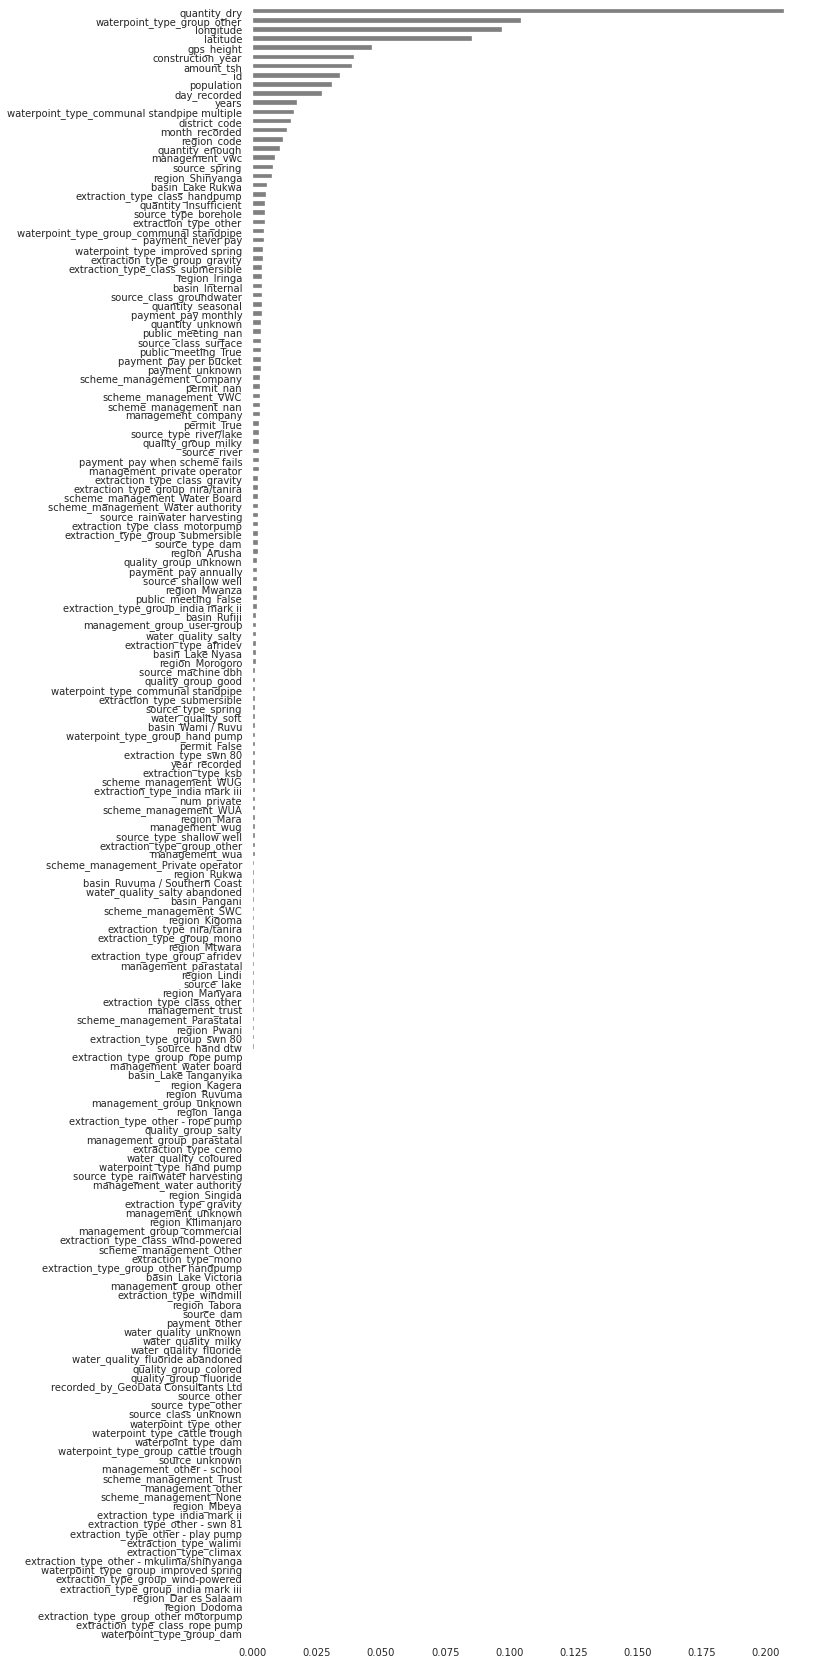

In [555]:
# features importance graph

model = pipeline.named_steps['decisiontreeclassifier']                  # 'grab' the model from the pipeline
encoder = pipeline.named_steps['onehotencoder']                         # 'grab the encoder from the pipeline.
encoded_columns = encoder.transform(X_val).columns                      # get the column names
coefficients = pd.Series(model.feature_importances_, encoded_columns)   # turn the coefficients into a dataframe with the names and coeff_ value

plt.figure(figsize=(10,30))
coefficients.sort_values().plot.barh(color='grey');

In [551]:
from sklearn.ensemble import RandomForestClassifier

# decision tree classifier model
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(max_depth=25, min_samples_leaf=5, random_state=42)
)

pipeline.fit(X_train,y_train)

# scores
print('Train score:', pipeline.score(X_train, y_train))


Train score: 0.834320987654321
Validation score: 0.8015488215488216


In [552]:
# # create submission 
# y_pred_test =  pipeline.predict(X_test)

# submission = test[['id']].copy()
# submission['status_group'] = y_pred_test

# # number of submissions: 1
# submission.to_csv('DecisionTreeClassifier-7-22-2020_3.csv', index=False)